## Vocab before advanced preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
path = '../thermofeeler/data/tokenized_dataset.csv'
df = pd.read_csv(path)

In [3]:
df = df.drop(columns=['Unnamed: 0'])
df_pos = df[df.encoded_sentiment == 1][:7000]
df_neg = df[df.encoded_sentiment == -1][:7000]
df_net = df[df.encoded_sentiment == 0][:7000]

In [4]:
small_df = pd.concat([df_pos, df_neg, df_net])

In [5]:
X = small_df.tweet_text
y = small_df.encoded_sentiment
y = pd.get_dummies(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14699,), (6301,), (14699, 3), (6301, 3))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train_token = tk.texts_to_sequences(X_train)
X_train_token[0]

[3, 61, 121, 62, 87, 603, 470, 100, 2546, 67, 1720, 752, 192, 817]

In [9]:
maxLength = max(len(x) for x in X_train_token)
minLength = min(len(x) for x in X_train_token)
vocab_size = len(tk.word_index)
maxLength, minLength, vocab_size

(41, 0, 24625)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_train_pad[0]

array([   3,   61,  121,   62,   87,  603,  470,  100, 2546,   67, 1720,
        752,  192,  817,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [12]:
def initialize_model():
    
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.01, l2=0.01)
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model = Sequential()
    embedding_size = 200
    model.add(Embedding(input_dim = vocab_size+1, input_length=50,
                        output_dim=embedding_size, mask_zero=True))
    
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=reg_l2))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax", kernel_regularizer=reg_l2))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

    return model

In [14]:
%%time
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

Epoch 1/200
368/368 [==============================] - 10s 23ms/step - loss: 1.5243 - accuracy: 0.5144 - val_loss: 1.3507 - val_accuracy: 0.6588
Epoch 2/200
368/368 [==============================] - 8s 22ms/step - loss: 1.1603 - accuracy: 0.6571 - val_loss: 1.0214 - val_accuracy: 0.6643
Epoch 3/200
368/368 [==============================] - 8s 22ms/step - loss: 0.9288 - accuracy: 0.6795 - val_loss: 0.8369 - val_accuracy: 0.6803
Epoch 4/200
368/368 [==============================] - 8s 22ms/step - loss: 0.7767 - accuracy: 0.6941 - val_loss: 0.7149 - val_accuracy: 0.7024
Epoch 5/200
368/368 [==============================] - 8s 22ms/step - loss: 0.6788 - accuracy: 0.7156 - val_loss: 0.6427 - val_accuracy: 0.7418
Epoch 6/200
368/368 [==============================] - 8s 22ms/step - loss: 0.6177 - accuracy: 0.7598 - val_loss: 0.5891 - val_accuracy: 0.7779
Epoch 7/200
368/368 [==============================] - 8s 22ms/step - loss: 0.5572 - accuracy: 0.8045 - val_loss: 0.5428 - val_accuracy

In [15]:
 model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 200)           4925200   
                                                                 
 lstm_1 (LSTM)               (None, 50)                50200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 4,978,103
Trainable params: 4,978,103
No

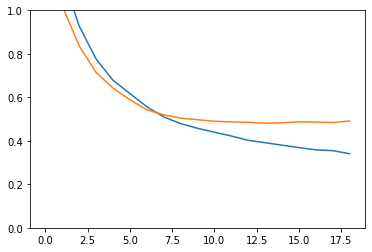

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1));

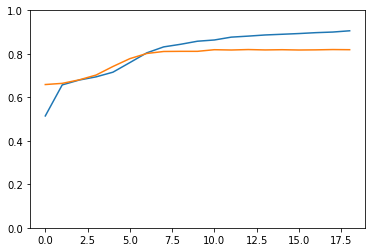

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0,1));

In [18]:
X_test_token = tk.texts_to_sequences(X_test)

In [19]:
X_test_pad = pad_sequences(X_test_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_test_pad[0]

array([699,  16, 554, 158,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [20]:
model.evaluate(X_test_pad, y_test, verbose=0)

[0.486697793006897, 0.8219330310821533]

## Vocab after advanced preprocessing

In [153]:
def remove_onomatopeia(tweet):
    for word in tweet:
        if word.count('k') >= 2: 
            word_ = 'kkkk'
            tweet[tweet.index(word)] = word_
    return tweet

In [154]:
def strip_accents(s):
    return (''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

In [155]:
std_list = {'é':'ser','eh':'ser','vc':'voce','vcs':'voces','tb': 'tambem','tbm': 'tambem', 
            'obg': 'obrigado','obrigada':'obrigado','gnt': 'gente', 'q': 'que', 'n': 'nao', 
            'cmg': 'comigo', 'p':'para','pra' :'para','ta': 'está','tá':'está','to': 'estou', 
            'vdd':'verdade','bjos':'beijo','bjo':'beijo','kd': 'cade', 'pq':'porque',
            'cmg':'comigo','cm':'com','pc':'ca','aq':'aqui','qdo':'quando','p':'para','k':'que','agr':'agora'}

verb_list = {'sou':'ser','es':'ser','somos':'ser','sao':'ser','era':'ser','eras':'ser','era':'ser',
             'eramos':'ser','ereis':'ser','eram':'ser', 'fui':'ser', 'foste':'ser', 'foi':'ser','fomos':'ser',
             'fostes':'ser','foram':'ser','fora':'ser','foras':'ser','fôramos':'ser','foreis':'ser', 'serei':'ser',
             'sera':'ser','seremos':'ser','sereis':'ser','serao':'ser', 'seria':'ser','serias':'ser',
             'seriamos':'ser','serieis':'ser','seriam':'ser','seja':'ser','sejas':'ser','seja':'ser',
             'sejamos':'ser','sejais':'ser','sejam':'ser','fosse':'ser','fosses':'ser','fosse':'ser',
             'fossemos':'ser','fosseis':'ser','fossem':'ser',
             'estou':'estar', 'esta':'estar', 'estamos':'estar', 'estao':'estar', 'estive':'estar', 
             'esteve':'estar','estivemos':'estar','estiveram':'estar', 'estava':'estar', 'estavamos':'estar', 
             'estavam':'estar', 'estivera':'estar', 'estivéramos':'estar', 'esteja':'estar', 'estejamos':'estar', 
             'estejam':'estar','estivesse':'estar', 'estivessemos':'estar', 'estivessem':'estar','estiver':'estar',
             'estivermos':'estar','estiverem':'estar', 'estaremos':'estar',
             'havia':'haver', 'houveram':'haver',
             'hei':'haver','ha':'haver','havemos':'haver','hao':'haver', 'houve':'haver', 'houvemos':'haver', 
             'houveram':'haver', 'houvera':'haver', 'houveramos':'haver', 'haja':'haver','hajamos':'haver', 
             'hajam':'haver', 'houvesse':'haver', 'houvessemos':'haver', 'houvessem':'haver', 'houver':'haver', 
             'houvermos':'haver', 'houverem':'haver','houverei':'haver', 'houveremos':'haver',
             'houverao':'haver', 'houveria':'haver', 'houveriamos':'haver', 'houveriam':'haver',
             'tenho':'ter', 'temos':'ter','tinha':'ter', 'tinhamos':'ter', 'tinham':'ter', 'tive':'ter', 
             'teve':'ter', 'tivemos':'ter', 'tiveram':'ter', 'tivera':'ter','tiveramos':'ter','tenha':'ter',
             'tenhamos':'ter', 'tenham':'ter', 'tivesse':'ter', 'tivessemos':'ter', 
             'tivessem':'ter', 'tiver':'ter', 'tivermos':'ter', 'tiverem':'ter', 'terei':'ter', 'tera':'ter',
             'teremos':'ter', 'terao':'ter', 'teria':'ter', 'teriamos':'ter', 'teriam':'ter', 'tem':'ter',
             'deve':'dever', 'devem':'dever', 'devendo':'dever', 'devera':'dever', 'deverao':'dever', 
             'deveria':'dever', 'deveriam':'dever', 'devia':'dever', 'deviam':'dever',
             'faz':'fazer','fazeis':'fazer','fazem':'fazer','fazemos':'fazer','fazendo':'fazer','fazes':'fazer',
             'faço':'fazer','fazia':'fazer','fazias':'fazer','fazia':'fazer','faziamos':'fazer','fazieis':'fazer',
             'faziam':'fazer','farei':'fazer','faras':'fazer','fara':'fazer','faremos':'fazer',
             'fareis':'fazer','farao':'fazer','faça':'fazer','faças':'fazer','faça':'fazer','façamos':'fazer',
             'façais':'fazer','façam':'fazer','fizesse':'fazer',
             'fizesses':'fazer','fizesse':'fazer','fizessemos':'fazer','fizesseis':'fazer','fizessem':'fazer',
             'quero':'querer','queres':'querer','quer':'querer','queremos':'querer','quereis':'querer',
             'querem':'querer','queria':'querer','querias':'querer','queria':'querer','queriamos':'querer',
             'querieis':'querer','queriam':'querer'}


In [156]:
def remove_abbreviation(tweet):
    for word in tweet:
        if word in std_list.keys():
            word_ = std_list[word]
            tweet[tweet.index(word)] = word_
    return tweet

In [157]:
def remove_conjugaison(tweet):
    for word in tweet:
        if word in verb_list.keys():
            word_ = verb_list[word]
            tweet[tweet.index(word)] = word_
    return tweet

In [191]:
def lemmatization(tweet):
    lemma = ""
    for sent in nlp(tweet).sentences:
        for word in sent.words:
            lemma += word.lemma + " "
    return lemma

In [186]:
import re
from nltk.tokenize import word_tokenize
import pandas as pd
import unicodedata
import stanza

stanza.download('pt')
nlp = stanza.Pipeline('pt')

2022-03-18 17:58:32 INFO: Downloading default packages for language: pt (Portuguese)...
2022-03-18 17:58:33 INFO: File exists: /Users/laurannefossat/stanza_resources/pt/default.zip.
2022-03-18 17:58:34 INFO: Finished downloading models and saved to /Users/laurannefossat/stanza_resources.
2022-03-18 17:58:34 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |

2022-03-18 17:58:34 INFO: Use device: cpu
2022-03-18 17:58:34 INFO: Loading: tokenize
2022-03-18 17:58:34 INFO: Loading: mwt
2022-03-18 17:58:34 INFO: Loading: pos
2022-03-18 17:58:34 INFO: Loading: lemma
2022-03-18 17:58:34 INFO: Loading: depparse
2022-03-18 17:58:34 INFO: Done loading processors!


In [197]:
def preproc_func(tweet):
    '''Does the preprocessing of the tweets'''
    
    tweet = tweet.lower() # lowercase
    
    tweet=re.sub('https?://[A-Za-z0-9./]+','',tweet) # remove links que começam com https?://
    tweet=re.sub('https://[A-Za-z0-9./]+','',tweet) # remove links que começam com https://
    tweet=re.sub('http://[A-Za-z0-9./]+','',tweet) # remove links que começam com http://
    
    tweet = re.sub(r'@[A-Za-z0-9_]+','',tweet) # remove @mentions
    tweet = re.sub(r'#',' ',tweet) # remove #hashtags
    
    tweet = re.sub(r'[^\w\s]','',tweet) # remove punctuation
    tweet = re.sub(r'[0-9]',' number',tweet) # remove numbers
    
    print('lemmatization')
    tweet = lemmatization(tweet)
    tweet = strip_accents(tweet) # remove accents
    print('tokenize')
    word_tokens=word_tokenize(tweet) # tokenize
    
    word_tokens = remove_onomatopeia(word_tokens) # remove onomatopeias
    word_tokens = remove_abbreviation(word_tokens) # remove abbreviations
    word_tokens = remove_conjugaison(word_tokens) # remove conjugaisons
    
    # stopwords: remove articles, prepositions, conjunctions etc
    stopwords=['a','ah','g','h', 'd','ca','te','tu','tua','tuas','um','uma','voce','voces','vos',
               'as','ao','aos','aquela','aquelas','aquele','aqueles','aquilo','as','ate','com','como','da','das',
               'de','dela','delas','dele','deles','depois','do','dos','e','ela','elas','ele','eles','em','entre',
               'essa','essas','esse','esses','eu','for','isso','isto','ja','lhe','lhes','me','mesmo','meu','meus',
               'minha','minhas','muito','na','nas','no','nos','nossa','nossas','nosso','nossos','num','numa',
               'nós','oh','o','os','para','pela','pelas','pelo','pelos','por','qual','quando','que','quem',
               'se','sem','seu','seus','somos','sou','sua','suas','so','tambem', 'mas','ou', 'nem', 
               'este','teu','teus','estes','estas','agora','ai','alem','algo','alguém','algum','ainda',
               'alguma','algumas','alguns', 'ali','ampla','amplas', 'amplo', 'amplos','ante', 'antes','apenas',
               'apoio','após','aqui','aquilo','assim','atrás','através','bastante','breve','cada', 'cedo', 'cento', 
               'certamente','certeza','cima','coisa','coisas','da','dao','daquela', 'daquelas','daquele',
               'daqueles','dentro','contudo','debaixo','demais','depois','desde','dessa','dessas','desse','desses',
               'desta','destas','deste','destes','embora','enquanto','entre','etc','feita','feitas','feito', 
               'feitos','for','fora','geral','grande','grandes','hoje', 'hora', 'horas', 'la', 'lo', 'longe',
               'lugar', 'maior','maioria','mais','meio', 'menor', 'menos', 'mes', 'meses','mesma', 'mesmas',
               'mesmo', 'mesmos','muita', 'muitas','muito','muitos','naquela', 'naquelas', 'naquele', 'naqueles',
               'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes','num', 'numa','onde',
               'ontem','perto','parte','outra', 'outras', 'outro', 'outros', 'pois', 'porém', 'porque',
               'possivel', 'possivelmente','pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras',
               'primeiro', 'primeiros','propria','proprias','proprio', 'proprios', 'proxima', 'proximas',
               'proximo', 'proximos','quais', 'quanto', 'quantos','quem','sempre','si', 'sido','sob', 'sobre',
               'tal', 'talvez','tampouco', 'tanta', 'tantas','tanto', 'tao', 'tarde', 'te', 'todo', 'todos',
               'toda', 'todas','tudo', 'ultima', 'ultimas', 'ultimo', 'ultimos','vários','vez', 'vezes',]
    
    filtered_tweet = [w for w in word_tokens if not w in stopwords] # remove stopwords

    return filtered_tweet

In [198]:
df_2 = pd.read_csv('../thermofeeler/data/encoded_df.csv')

In [199]:
df_2.tweet_text.head()

0    @dilsonramoslima #Fato Acho que o Roger é um b...
1    #NOVIDADE! @LATAM_BRA acaba de anunciar novo v...
2    Quando tem #novidade😆 tem @novafm103 na área! ...
3    @RiodeNojeira #Novidade Taí o sucesso dos filh...
4    [Livro/Novidades] Segredos, uma história de Lu...
Name: tweet_text, dtype: object

In [ ]:
df_2.tweet_text = df_2.tweet_text.apply(preproc_func)

lemmatization
tokenize
lemmatization


/Users/laurannefossat/.pyenv/versions/3.8.12/envs/thermofeeler/lib/python3.8/site-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
lemmatization
tokenize
le

In [ ]:
df_2.tweet_text.head()

In [ ]:
df_2 = df_2.drop(columns=['Unnamed: 0'])
df_pos_2 = df_2[df_2.encoded_sentiment == 1][:7000]
df_neg_2 = df_2[df_2.encoded_sentiment == -1][:7000]
df_net_2 = df_2[df_2.encoded_sentiment == 0][:7000]

In [ ]:
small_df_2 = pd.concat([df_pos_2, df_neg_2, df_net_2])

In [ ]:
X_2 = small_df_2.tweet_text
y_2 = small_df_2.encoded_sentiment
y_2 = pd.get_dummies(y_2)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2, train_size=0.7, random_state=1)

In [ ]:
tk_2 = Tokenizer()
tk_2.fit_on_texts(X_train_2)
X_train_token_2 = tk_2.texts_to_sequences(X_train_2)

In [ ]:
maxLength_2 = max(len(x) for x in X_train_token_2)
minLength_2 = min(len(x) for x in X_train_token_2)
vocab_size_2 = len(tk_2.word_index)
maxLength_2, minLength_2, vocab_size_2

In [182]:
X_train_pad_2 = pad_sequences(X_train_token_2, dtype='int32', padding='post', value=0, maxlen=50)

In [183]:
%%time
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad_2, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

Epoch 1/200
368/368 [==============================] - 11s 25ms/step - loss: 1.4925 - accuracy: 0.4549 - val_loss: 1.3057 - val_accuracy: 0.5762
Epoch 2/200
368/368 [==============================] - 8s 23ms/step - loss: 1.1427 - accuracy: 0.6401 - val_loss: 1.0035 - val_accuracy: 0.6728
Epoch 3/200
368/368 [==============================] - 8s 23ms/step - loss: 0.9065 - accuracy: 0.6814 - val_loss: 0.8168 - val_accuracy: 0.6687
Epoch 4/200
368/368 [==============================] - 8s 22ms/step - loss: 0.7500 - accuracy: 0.6740 - val_loss: 0.6936 - val_accuracy: 0.6656
Epoch 5/200
368/368 [==============================] - 8s 22ms/step - loss: 0.6555 - accuracy: 0.6771 - val_loss: 0.6279 - val_accuracy: 0.6714
Epoch 6/200
368/368 [==============================] - 8s 23ms/step - loss: 0.6110 - accuracy: 0.6857 - val_loss: 0.5977 - val_accuracy: 0.6918
Epoch 7/200
368/368 [==============================] - 8s 23ms/step - loss: 0.5851 - accuracy: 0.6998 - val_loss: 0.5786 - val_accuracy

In [184]:
X_test_token_2 = tk_2.texts_to_sequences(X_test_2)
X_test_pad_2 = pad_sequences(X_test_token_2, dtype='int32', padding='post', value=0, maxlen=50 )

In [185]:
model.evaluate(X_test_pad_2, y_test_2, verbose=0)

[0.5037486553192139, 0.7974924445152283]